# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.

**Цель** - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта:**

исследовательский анализ набора фотографий,

обучение нейронной сети и рассчет её качества.

## Исследовательский анализ данных

**Загрузка библиотек**

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

**Размер выборки**

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale = 1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        batch_size = 16,
        class_mode = 'raw',
        seed = 12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels['file_name'].duplicated().sum()

0

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**График распределения возраста в выборке**

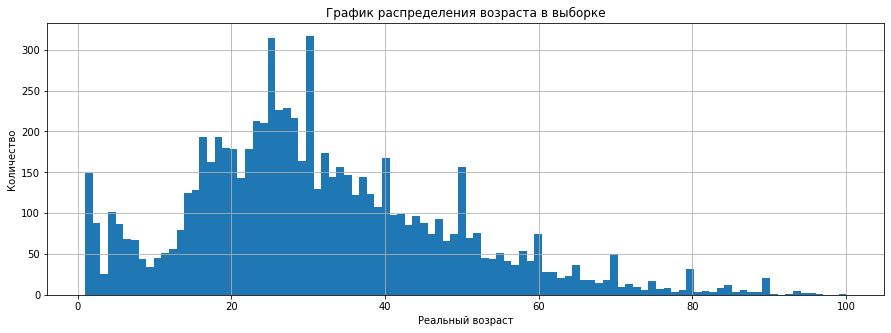

In [6]:
plt.figure(figsize=(15,5))
plt.title('График распределения возраста в выборке')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество')
labels.real_age.hist(bins=100);

**Распределение по возрастным группам**

In [8]:
labels['age'] = pd.cut(
    labels.real_age,
    bins = [0, 18, 44, 60, 75, 89, 100],
    labels=['дети до 18 лет', 'молодость 19-43 лет', 
            'средний возраст 44-60 лет',
            'пожилой человек 61-75 лет', 'старческий период 76-89 лет',
            'долгожители от 90 лет']
)

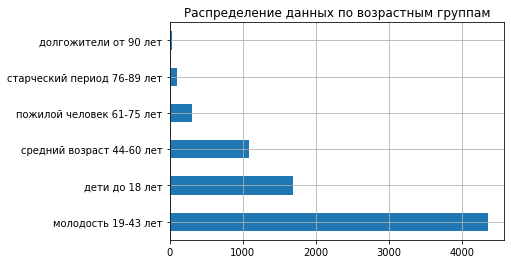

In [9]:
labels.age.value_counts().plot(
    kind = 'barh', grid = True,
    title = 'Распределение данных по возрастным группам'
);

In [10]:
kids = labels['real_age'] < 18
mol_mean = (labels['real_age'] >= 19) & (labels['real_age'] <= 60)
star = labels['real_age'] >= 61

print(f'''
Доля данных в датасете по возрастным группам:
      
1. Детский возраст: {kids.mean():.2%}
2. Молодость и средний возраст: {mol_mean.mean():.2%}
3. Пожилые и старики: {star.mean():.2%}
''')


Доля данных в датасете по возрастным группам:
      
1. Детский возраст: 19.80%
2. Молодость и средний возраст: 71.78%
3. Пожилые и старики: 5.88%



**Печать 15 фотографий**

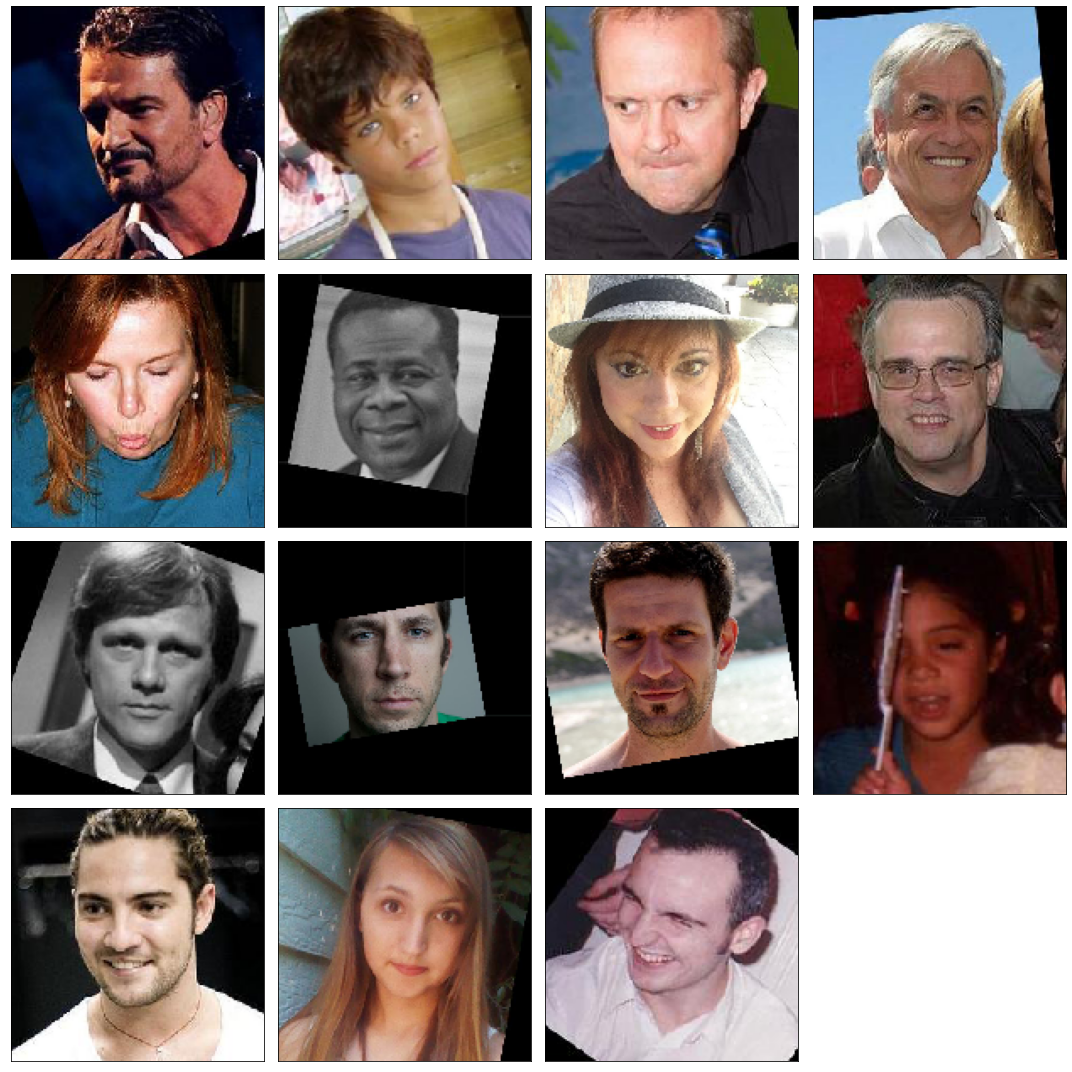

In [13]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод по исследованию**

Данные состоят из папки с фотографиями людей, файла в формате csv, который содержит имена файлов и возраст человека на фото.

Всего найдено 7591 файл. Пропусков нет, дубликаты не обнаружены, тип данных - верный.

С помощью метода describe было выявлено, что минимальный возраст - 1 год, средний возраст - 31 год, а максимальный возраст - 100 лет.

Построен график распределения возраста в выборке и дополнительно подсчитаны доли данных по возрастным группам (Согласно Всемирной Организации Здравоохранения были разделены люди на группы и категории)

## Обучение модели

**Код обучения модели**

```python

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50>

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        horizontal_flip = True,
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150, 150),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape = input_shape,weights = 'imagenet',include_top = False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'relu'))
    optimizer = Adam(lr = 0.0001)
    model.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['mae'])

    return model

def train_model(model, train_data, test_data, batch_size = None, epochs=10,
                steps_per_epoch = None, validation_steps = None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size, epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose=2)
    return model

```

**Вывод результата**

```

2023-11-03 16:20:31.987349: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-11-03 16:20:31.989643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-11-03 16:20:32.828729: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-11-03 16:20:32.837468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-11-03 16:20:32.837530: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-03 16:20:32.837561: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-03 16:20:32.839834: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-11-03 16:20:32.840261: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-11-03 16:20:32.842634: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-11-03 16:20:32.843916: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-11-03 16:20:32.843980: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-11-03 16:20:32.847328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-11-03 16:20:33.015624: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-11-03 16:20:33.021465: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-11-03 16:20:33.022023: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x404efd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-03 16:20:33.022055: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-03 16:20:33.172132: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x36af130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-03 16:20:33.172169: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-11-03 16:20:33.173836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-11-03 16:20:33.173889: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-03 16:20:33.173899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-03 16:20:33.173923: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-11-03 16:20:33.173932: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-11-03 16:20:33.173941: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-11-03 16:20:33.173950: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-11-03 16:20:33.173957: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-11-03 16:20:33.177198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-11-03 16:20:33.177274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-11-03 16:20:33.495913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-11-03 16:20:33.495962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-11-03 16:20:33.495970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-11-03 16:20:33.499055: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-11-03 16:20:33.499103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 6s
  237568/94765736 [..............................] - ETA: 20s
 1196032/94765736 [..............................] - ETA: 7s 
 6864896/94765736 [=>............................] - ETA: 1s
14041088/94765736 [===>..........................] - ETA: 1s
21700608/94765736 [=====>........................] - ETA: 0s
29327360/94765736 [========>.....................] - ETA: 0s
36708352/94765736 [==========>...................] - ETA: 0s
44523520/94765736 [=============>................] - ETA: 0s
51855360/94765736 [===============>..............] - ETA: 0s
59637760/94765736 [=================>............] - ETA: 0s
67076096/94765736 [====================>.........] - ETA: 0s
74727424/94765736 [======================>.......] - ETA: 0s
82427904/94765736 [=========================>....] - ETA: 0s
89899008/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-11-03 16:20:44.583523: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-03 16:20:44.881769: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 46s - loss: 10.9075 - mae: 10.9077 - val_loss: 17.6571 - val_mae: 17.6530
Epoch 2/10
356/356 - 36s - loss: 7.4059 - mae: 7.4067 - val_loss: 8.8421 - val_mae: 8.8282
Epoch 3/10
356/356 - 36s - loss: 6.1144 - mae: 6.1147 - val_loss: 8.1310 - val_mae: 8.1345
Epoch 4/10
356/356 - 36s - loss: 5.1738 - mae: 5.1740 - val_loss: 6.8556 - val_mae: 6.8593
Epoch 5/10
356/356 - 36s - loss: 4.5050 - mae: 4.5053 - val_loss: 6.6419 - val_mae: 6.6458
Epoch 6/10
356/356 - 36s - loss: 4.0330 - mae: 4.0332 - val_loss: 6.9184 - val_mae: 6.9307
Epoch 7/10
356/356 - 36s - loss: 3.6166 - mae: 3.6166 - val_loss: 6.6032 - val_mae: 6.6052
Epoch 8/10
356/356 - 36s - loss: 3.2863 - mae: 3.2864 - val_loss: 6.3312 - val_mae: 6.3351
Epoch 9/10
356/356 - 36s - loss: 3.1280 - mae: 3.1282 - val_loss: 6.2625 - val_mae: 6.2696
Epoch 10/10
356/356 - 37s - loss: 2.9588 - mae: 2.9589 - val_loss: 6.3418 - val_mae: 6.3496
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 6.3418 - mae: 6.3496
Test MAE: 6.3496

```

## Анализ обученной модели

Использовалась архитектура свёрточной нейронной сети ResNet50, которая была предобученна на наборе ImageNet, что значительно сокращает время обучения.

Метрика MAE - 6.3496 - задача выполнена. 

Модель хорошо справляется с определением возраста покупателей.